In [5]:
from src import SQL_Executor, SQL_Queries, Vizualizator
import pandas as pd
import numpy as np

executor = SQL_Executor()
query = SQL_Queries.Payment()
df = executor.execute_query(query.define_dpd_aggregate())
t_df = executor.execute_query(query.calculate_dpd90_trend())

In [6]:
dpd = df.copy()
scheduled_date = pd.to_datetime(dpd["scheduled_date"])
payment_date = pd.to_datetime(dpd["payment_date"])
today = pd.Timestamp.today()

conditions = [
    payment_date > scheduled_date,
    payment_date.isna(),
    payment_date <= scheduled_date,
]

choices = [
    (payment_date - scheduled_date).dt.days,
    np.maximum((today - scheduled_date).dt.days, 0),
    0,
]

dpd["dpd"] = np.select(conditions, choices, default=0)
dpd = dpd.drop(columns=["payment_date", "scheduled_date"])

dpd90 = dpd.copy()
dpd90["dpd90"] = (dpd90["dpd"] >= 90).astype(int)
dpd90 = dpd90.groupby("transaction_id").agg({"dpd90": "max"})
dpd90 = t_df.merge(dpd90, on="transaction_id", how="left")
dpd90

,transaction_id,user_id,age,income,dpd90
0,1,7,21,30000,0
1,2,9,25,49000,0
2,3,10,25,62000,0
3,4,4,25,32500,1
4,5,8,20,29500,1
...,...,...,...,...,...
44618,44619,714,32,62500,1
44619,44620,215,25,44500,1
44620,44621,714,32,62500,1
44621,44622,665,36,53500,1


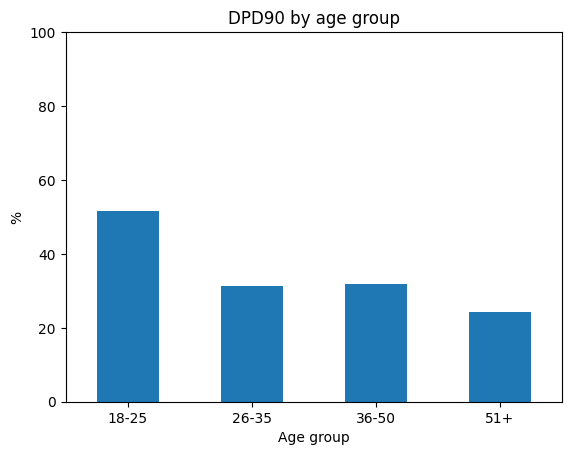

In [7]:
bins = [18, 26, 36, 51]
dpd90_rates_age = Vizualizator(dpd90)
dpd90_rates_age.group_by_column(bins, "dpd90", "age", "income")
dpd90_rates_age.visualize(
    column="dpd90_rate",
    kind="bar",
    ylim=(0, 100),
    title="DPD90 by age group",
    rotation=0,
    xlabel="Age group",
    ylabel="%",
)

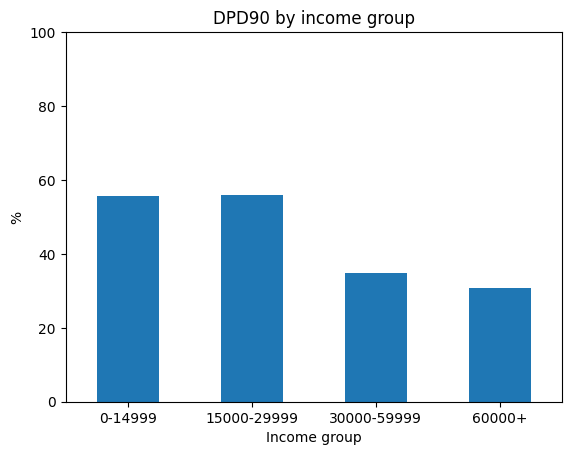

In [8]:
bins = [0, 15000, 30000, 60000]
dpd90_rates_income = Vizualizator(dpd90)
dpd90_rates_income.group_by_column(bins, "dpd90", "income", "age")
dpd90_rates_income.visualize(
    column="dpd90_rate",
    kind="bar",
    ylim=(0, 100),
    title="DPD90 by income group",
    rotation=0,
    xlabel="Income group",
    ylabel="%",
)